In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/AN2DL/ExerciseSession8

/gdrive/My Drive/AN2DL/ExerciseSession8


In [3]:
import tensorflow as tf
import numpy as np
import io
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import scipy.io as sio

from plotly.subplots import make_subplots
import plotly.graph_objects as go

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Neural Machine Translation (Italian/English)

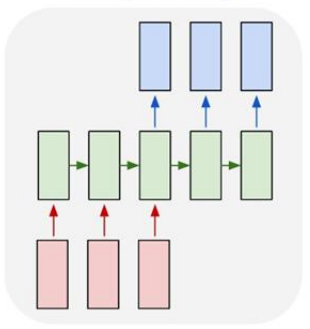

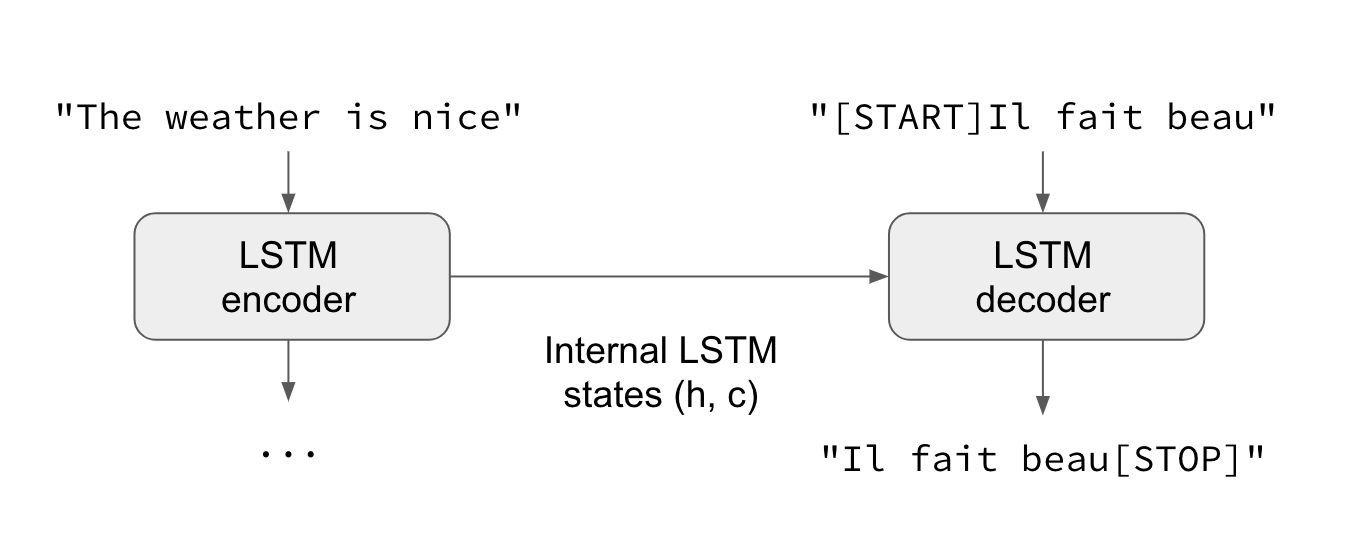

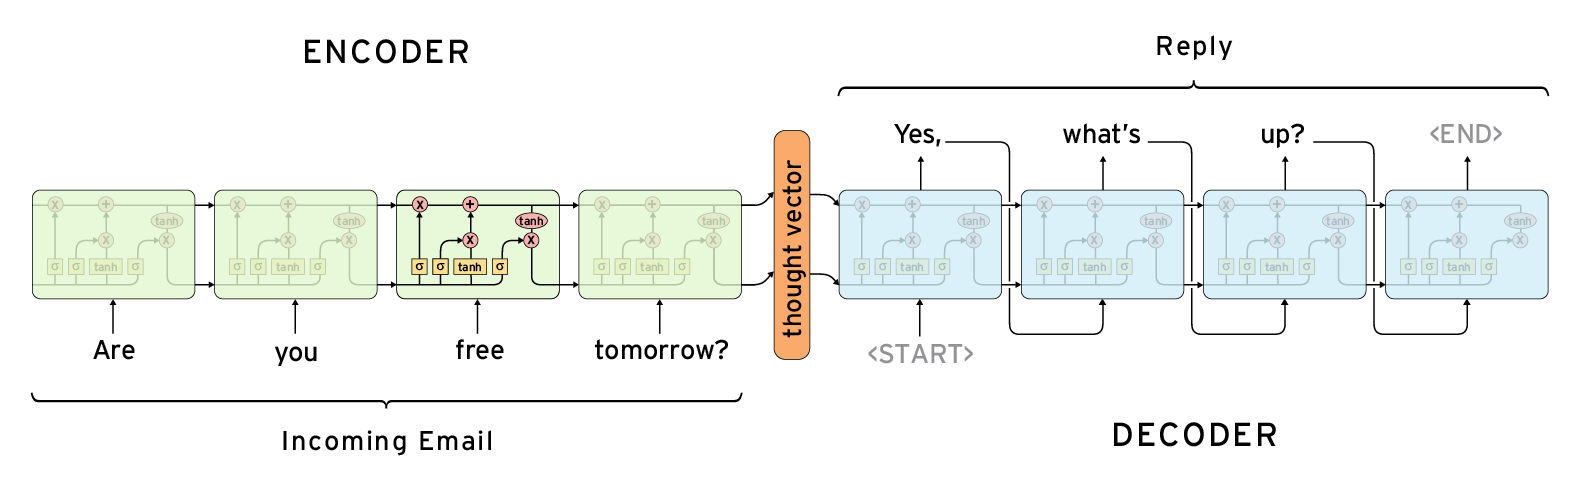

# Load Dataset

Dataset source: http://www.manythings.org/anki/

In [5]:
!head -100 ita.txt

Hi.	Ciao!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)
Run!	Corri!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906347 (Guybrush88)
Run!	Corra!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906348 (Guybrush88)
Run!	Correte!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906350 (Guybrush88)
Who?	Chi?	CC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #2126402 (Guybrush88)
Wow!	Wow!	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #1922050 (Guybrush88)
Jump!	Salta!	CC-BY 2.0 (France) Attribution: tatoeba.org #1102981 (jamessilver) & #1543215 (Guybrush88)
Jump!	Salti!	CC-BY 2.0 (France) Attribution: tatoeba.org #1102981 (jamessilver) & #4356755 (Guybrush88)
Jump!	Saltate!	CC-BY 2.0 (France) Attribution: tatoeba.org #1102981 (jamessilver) & #4356756 (Guybrush88)
Jump.	Salta.	CC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishir) & #2416939 (Guybrush88)
Jump.	Salti.	CC-BY 2.0

## Prepare training dataset

In [6]:
# Divide italian and english sentences
# ------------------------------------

def read_txt(txt_file):

  ita_sentences = []
  eng_sentences = []
  eng_sentences_train = []

  # Read all the lines in the file
  count = 0
  for line in open(txt_file, encoding='utf-8'):
      
      # Each line is eng + \t + ita + \t + other stuff
      # Split by '\t' char
      if '\t' not in line:  
          continue
      eng_sentence, ita_sentence, _ = line.rstrip().split('\t')
      
      eng_sentences.append(eng_sentence)
      ita_sentences.append(ita_sentence)
      count += 1

  return eng_sentences, ita_sentences 

In [7]:
# Get english-italian sentence pairs
eng_sentences, ita_sentences = read_txt('ita.txt')

In [8]:
# Number of total english sentences
tot_eng = len(eng_sentences)
print("Number of english sentences:", tot_eng)
# Number of total italian sentences
tot_ita = len(ita_sentences)
print("Number of italian sentences:", tot_ita)

# Compute number of words per sentence
words_per_eng_sentence = [len(s.split(' ')) for s in eng_sentences]
words_per_ita_sentence = [len(s.split(' ')) for s in ita_sentences]

fig = make_subplots(rows=2, cols=1, subplot_titles=("Words per english sentence", "Words per italian sentence"))

fig.add_trace(
    go.Histogram(x=words_per_eng_sentence),
    row=1, col=1
)
fig.add_trace(
    go.Histogram(x=words_per_ita_sentence),
    row=2, col=1
)
fig.update_layout(height=800, title_text="Words per sentence", showlegend=False)
fig.show()

Number of english sentences: 331799
Number of italian sentences: 331799


In [9]:
# Add special words SOS and EOS to identify the start and the end of the translated sentence, respectively
eng_sentences = ['SOS ' + s + ' EOS' for s in eng_sentences]

## Keras Tokenizer



*   Allows to automatically extract words from text
*   Allows to automatically filter chars from text



In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Create the english Tokenizer
eng_tokenizer = Tokenizer(num_words=None,  # Max number of words to consider
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',  # filter all punctuation except "'" (simplification)
                          lower=True,  # convert all words to lowercase
                          split=' ')  # Find words by splitting by space ' '
# Fit the tokenizer on english sentences
eng_tokenizer.fit_on_texts(eng_sentences)

# Create the italian Tokenizer
ita_tokenizer = Tokenizer(num_words=None, 
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                          lower=True, 
                          split=' ')
# Fit the tokenizer on italian sentences
ita_tokenizer.fit_on_texts(ita_sentences)

In [11]:
# Print automatically gathered information
print("English word counts dictionary")
eng_word_counts = {k: v for k, v in sorted(eng_tokenizer.word_counts.items(), key=lambda item: item[1], reverse=True)}
print(eng_word_counts)  # reverse sorted by frequency
print()

fig = go.Figure(data=go.Scatter(y=[v for k,v in eng_word_counts.items()], x=[k for k,v in eng_word_counts.items()]))
fig.update_layout(height=300, title_text="English word counts", showlegend=False)
fig.show()

# Dictionary where keys are words and values are automatically assigned integer encodings (already ordered by frequency)
print("English word index dictionary (0 index is reserved for padding)")
print(eng_tokenizer.word_index)
print()

# Print automatically gathered information
print("Italian word counts dictionary")
ita_word_counts = {k: v for k, v in sorted(ita_tokenizer.word_counts.items(), key=lambda item: item[1], reverse=True)}
print(ita_word_counts)  # reverse sorted by frequency
print()

fig = go.Figure(data=go.Scatter(y=[v for k,v in ita_word_counts.items()], x=[k for k,v in ita_word_counts.items()]))
fig.update_layout(height=300, title_text="Italian word counts", showlegend=False)
fig.show()

# Dictionary where keys are words and values are automatically assigned integer encodings (already ordered by frequency)
print("Italian word index dictionary (0 index is reserved for padding)")
print(ita_tokenizer.word_index)
print()

English word counts dictionary
{'sos': 331799, 'eos': 331799, 'you': 78874, 'tom': 78085, 'i': 76018, 'to': 65640, 'the': 47645, 'a': 40643, 'is': 34722, 'do': 23635, 'he': 19684, 'that': 19136, 'have': 18462, 'in': 18195, 'it': 17971, 'me': 16839, 'was': 16324, "don't": 16170, "i'm": 15938, 'of': 15747, 'are': 14974, 'this': 14604, 'be': 12752, 'for': 12581, 'we': 12342, 'my': 12181, 'your': 12116, 'want': 10966, 'what': 10571, 'like': 9746, 'with': 9731, 'not': 9578, 'why': 9496, 'mary': 9311, 'did': 9036, 'know': 9028, "you're": 8582, 'go': 7888, 'think': 7837, 'his': 7741, 'she': 7529, 'at': 7432, 'can': 7358, 'here': 7137, 'very': 6980, "didn't": 6958, 'on': 6824, 'and': 6265, 'will': 6166, 'how': 5919, 'they': 5830, 'has': 5688, 'now': 5367, "can't": 5325, 'about': 5305, "it's": 5213, 'all': 5003, "isn't": 4992, 'going': 4966, 'were': 4628, 'there': 4569, 'so': 4541, 'get': 4293, "i'll": 4216, 'need': 4213, 'help': 4170, 'boston': 4118, 'as': 4102, 'time': 4066, 'him': 3869, "i'v

English word index dictionary (0 index is reserved for padding)
{'sos': 1, 'eos': 2, 'you': 3, 'tom': 4, 'i': 5, 'to': 6, 'the': 7, 'a': 8, 'is': 9, 'do': 10, 'he': 11, 'that': 12, 'have': 13, 'in': 14, 'it': 15, 'me': 16, 'was': 17, "don't": 18, "i'm": 19, 'of': 20, 'are': 21, 'this': 22, 'be': 23, 'for': 24, 'we': 25, 'my': 26, 'your': 27, 'want': 28, 'what': 29, 'like': 30, 'with': 31, 'not': 32, 'why': 33, 'mary': 34, 'did': 35, 'know': 36, "you're": 37, 'go': 38, 'think': 39, 'his': 40, 'she': 41, 'at': 42, 'can': 43, 'here': 44, 'very': 45, "didn't": 46, 'on': 47, 'and': 48, 'will': 49, 'how': 50, 'they': 51, 'has': 52, 'now': 53, "can't": 54, 'about': 55, "it's": 56, 'all': 57, "isn't": 58, 'going': 59, 'were': 60, 'there': 61, 'so': 62, 'get': 63, "i'll": 64, 'need': 65, 'help': 66, 'boston': 67, 'as': 68, 'time': 69, 'him': 70, "i've": 71, 'an': 72, 'us': 73, 'good': 74, "tom's": 75, 'had': 76, 'tell': 77, 'really': 78, 'never': 79, 'one': 80, 'too': 81, 'would': 82, 'still': 

Italian word index dictionary (0 index is reserved for padding)
{'tom': 1, 'non': 2, 'è': 3, 'di': 4, 'a': 5, 'che': 6, 'io': 7, 'la': 8, 'il': 9, 'un': 10, 'ha': 11, 'sono': 12, 'per': 13, 'in': 14, 'mi': 15, 'ho': 16, 'una': 17, 'con': 18, 'lei': 19, 'mary': 20, 'perché': 21, 'molto': 22, 'le': 23, 'questo': 24, 'lo': 25, 'da': 26, 'si': 27, 'i': 28, 'lui': 29, 'voi': 30, 'era': 31, 'noi': 32, 'più': 33, 'cosa': 34, 'essere': 35, 'e': 36, 'sei': 37, 'tu': 38, 'me': 39, 'sta': 40, 'qui': 41, 'fare': 42, 'mai': 43, 'suo': 44, 'ci': 45, 'voglio': 46, 'come': 47, 'vero': 48, 'mio': 49, 'sia': 50, 'così': 51, 'penso': 52, 'del': 53, 'ancora': 54, 'casa': 55, 'questa': 56, 'siete': 57, 'sua': 58, 'andare': 59, 'mia': 60, 'al': 61, 'detto': 62, 'hai': 63, 'fatto': 64, 'avete': 65, 'boston': 66, 'piace': 67, 'ti': 68, 'siamo': 69, 'quello': 70, 'posso': 71, 'loro': 72, 'alla': 73, 'stato': 74, 'vi': 75, 'abbiamo': 76, 'se': 77, 'tutto': 78, 'tutti': 79, 'ora': 80, 'francese': 81, 'so': 82, '

In [12]:
# Tokenize sentences assigning each word to the corresponding integer label
# -------------------------------------------------------------------------

# Tokenize english sentences
tokenized_eng_sentences = eng_tokenizer.texts_to_sequences(eng_sentences)

# Tokenize italian sentences
tokenized_ita_sentences = ita_tokenizer.texts_to_sequences(ita_sentences)

print("Tokenized english sentences (first 100)")
print({s: t_s for s, t_s in zip(eng_sentences[:100], tokenized_eng_sentences[:100])})
print()
print("Tokenized italian sentences (first 100)")
print({s: t_s for s, t_s in zip(ita_sentences[:100], tokenized_ita_sentences[:100])})
print()

Tokenized english sentences (first 100)
{'SOS Hi. EOS': [1, 2470, 2], 'SOS Run! EOS': [1, 555, 2], 'SOS Who? EOS': [1, 99, 2], 'SOS Wow! EOS': [1, 2519, 2], 'SOS Jump! EOS': [1, 2101, 2], 'SOS Jump. EOS': [1, 2101, 2], 'SOS Stop! EOS': [1, 196, 2], 'SOS Wait! EOS': [1, 239, 2], 'SOS Wait. EOS': [1, 239, 2], 'SOS Do it. EOS': [1, 10, 15, 2], 'SOS Go on. EOS': [1, 38, 47, 2], 'SOS Hello! EOS': [1, 1570, 2], 'SOS I ran. EOS': [1, 5, 701, 2], 'SOS I see. EOS': [1, 5, 86, 2], 'SOS I try. EOS': [1, 5, 201, 2], 'SOS I won! EOS': [1, 5, 532, 2], 'SOS I won. EOS': [1, 5, 532, 2], 'SOS Oh no! EOS': [1, 1805, 96, 2], 'SOS Relax. EOS': [1, 1242, 2], 'SOS Shoot! EOS': [1, 1215, 2], 'SOS Smile. EOS': [1, 915, 2], 'SOS Attack! EOS': [1, 1389, 2], 'SOS Cheers! EOS': [1, 7318, 2], 'SOS Eat it. EOS': [1, 122, 15, 2], 'SOS Eat up. EOS': [1, 122, 89, 2], 'SOS Freeze! EOS': [1, 4443, 2], 'SOS Get up. EOS': [1, 63, 89, 2], 'SOS Go now. EOS': [1, 38, 53, 2], 'SOS Got it! EOS': [1, 91, 15, 2], 'SOS He ran. EO

### Create a custom data generator

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# In the following A POSSIBLE implementation
class TextDataGenerator(tf.keras.utils.Sequence):

  def __init__(self,
               tokenized_eng_sentences,   
               tokenized_ita_sentences,
               eng_word_counts,
               ita_word_counts, 
               validation_split=0.1,
               which_subset='training',
               batch_size=8,
               shuffle=False):
    
    # Save data information
    num_eng_words = len(eng_word_counts)
    num_ita_words = len(ita_word_counts)

    max_eng_seq_length = max([len(t_s) for t_s in tokenized_eng_sentences]) 
    max_ita_seq_length = max([len(t_s) for t_s in tokenized_ita_sentences])

    # Compute incremental indices for all the sentences in the dataset
    indices = np.arange(len(tokenized_eng_sentences))
    
    # Split in training and validation
    num_valid_samples = int(len(indices)*validation_split)
    train_subset = indices[:-num_valid_samples]
    valid_subset = indices[-num_valid_samples:]

    # Select which subset to load
    if which_subset == 'training':
      self.indices = train_subset
    elif which_subset == 'validation':
      self.indices = valid_subset 

    print("Found {} sentences in the {} subset".format(len(self.indices), which_subset))

    # Save dataset parameters as class attributes
    self.which_subset = which_subset
    self.num_eng_words = num_eng_words
    self.num_ita_words = num_ita_words
    self.tokenized_ita_sentences = tokenized_ita_sentences
    self.tokenized_eng_sentences = tokenized_eng_sentences
    self.max_eng_seq_length = max_eng_seq_length
    self.max_ita_seq_length = max_ita_seq_length
    self.batch_size = batch_size
    self.shuffle = shuffle

  def __len__(self):
    # Return the length of the dataset (number of batches)
    # that is given by # number-of-sequences // batch_size
    return len(self.indices) // self.batch_size

  def on_epoch_start(self):
    # Shuffle indices after each epoch
    if self.shuffle == True:
        np.random.shuffle(self.indices)

  def __getitem__(self, index):
    # In this function we generate a batch (of size self.batch_size) of three components
    # - Encoder input (ita)
    # - Decoder input (eng)
    # - Target (eng)
    
    # Get 'self.batch_size' indices
    current_indices = self.indices[index*self.batch_size:(index*self.batch_size)+self.batch_size]

    # Init lists that will contain inputs and target
    batch_encoder_input = []
    batch_decoder_input = []
    batch_target = []

    # Cycle over the indices
    for idx in current_indices:
      # Get single ita/eng sentences
      ita_sentence = self.tokenized_ita_sentences[idx]
      eng_sentence = self.tokenized_eng_sentences[idx]

      # Decoder eng input <- remove EOS  |  Decoder input: SOS Aa Bb Cc Dd Ee 
      decoder_input = eng_sentence[:-1]
      # Target <- remove SOS             |  Target:         Aa Bb Cc Dd Ee EOS
      target = eng_sentence[1:]

      # Pad all the sentences to the maximum sequence length in the dataset (for both italian and english languages)
      ita_sentence = pad_sequences([ita_sentence], maxlen=self.max_ita_seq_length)  # padding default 'pre'
      decoder_input = pad_sequences([decoder_input], maxlen=self.max_eng_seq_length-1, padding='post')
      target = pad_sequences([target], maxlen=self.max_eng_seq_length-1, padding='post')

      batch_encoder_input.append(ita_sentence)  # Encoder ita input
      batch_decoder_input.append(decoder_input)  
      batch_target.append(target)  
     
    # Finally, obtain a final batch by concatenating over the batch dimension
    batch_encoder_input = np.concatenate(batch_encoder_input, axis=0)
    batch_decoder_input = np.concatenate(batch_decoder_input, axis=0)
    batch_target = np.concatenate(batch_target, axis=0)

    return [batch_encoder_input, batch_decoder_input], batch_target

In [14]:
# Random shuffle the dataset
indices = np.arange(len(tokenized_eng_sentences))
np.random.shuffle(indices)
tokenized_ita_sentences = [tokenized_ita_sentences[idx] for idx in indices]
tokenized_eng_sentences = [tokenized_eng_sentences[idx] for idx in indices]

train_dataset = TextDataGenerator(tokenized_eng_sentences, tokenized_ita_sentences,
                                  eng_word_counts, ita_word_counts, validation_split=0.1,
                                  which_subset='training', batch_size=512, shuffle=True)
valid_dataset = TextDataGenerator(tokenized_eng_sentences, tokenized_ita_sentences,
                                  eng_word_counts, ita_word_counts, validation_split=0.1,
                                  which_subset='validation', batch_size=512, shuffle=False)

Found 298620 sentences in the training subset
Found 33179 sentences in the validation subset


# Sequence to Sequence Model

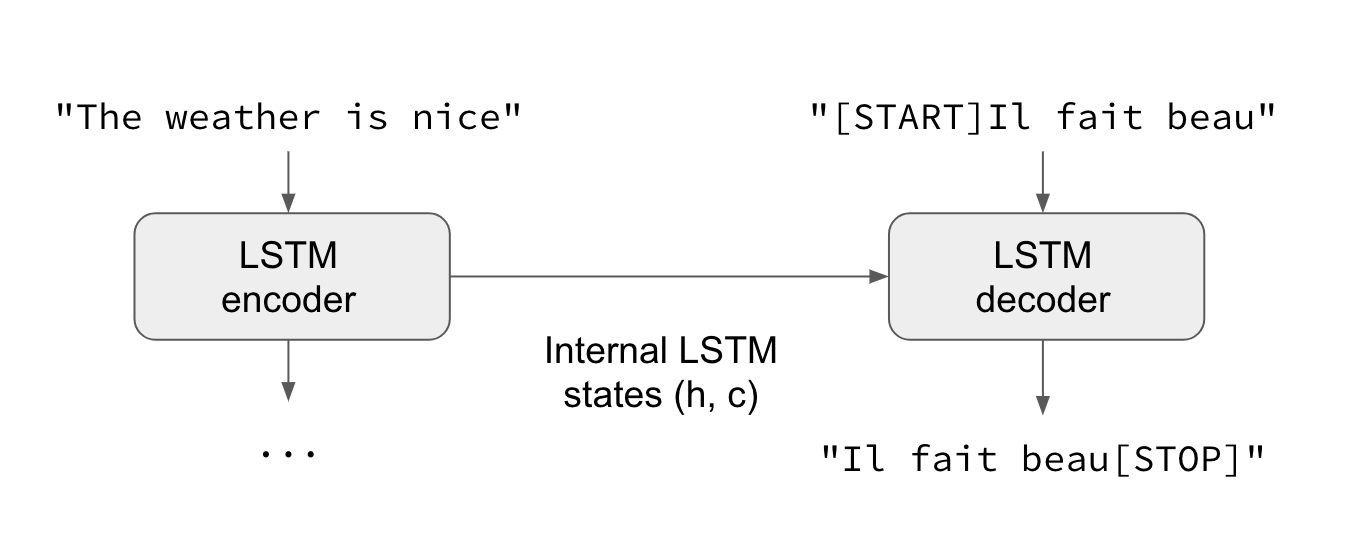

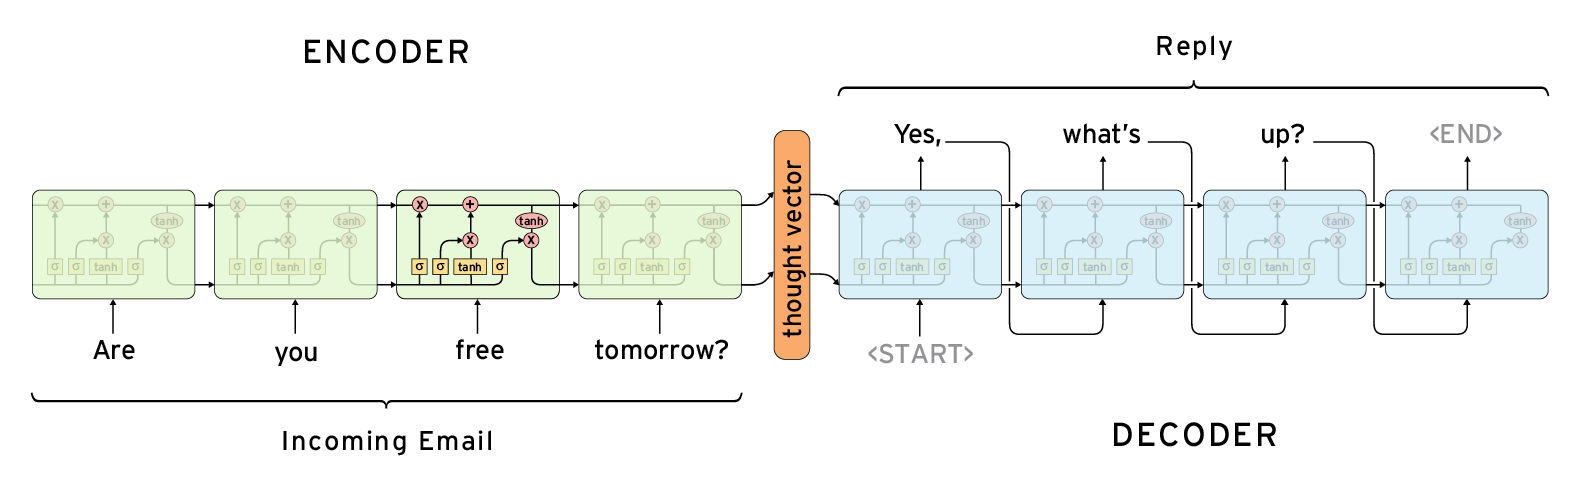

## Keywords

*   Encoder-Decoder recurrent architecture
*   Teacher forcing (training) - Prediction propagation (inference)
*   Word Embedding
    * Two learning strategies:
      * Learned from zero
        * In 2 steps. First train an embedding layer (e.g., word2vec) and then use it in the current task
        * Directly in the current task jointly with the other model parameters
      * 'Transfer Learning': import pre-trained word embedding



In [15]:
# Function to create the model 
def sequence2sequence(ita_vocabulary_len, eng_vocabulary_len,
                      max_ita_seq_length, max_eng_seq_length, 
                      ita_embedding_size, eng_embedding_size):
    
    # Build Encoder-Decoder Model
    # ---------------------------

    # ENCODER
    # -------
    encoder_input = tf.keras.Input(shape=[max_ita_seq_length], name='encoder_input')
    encoder_embedding = tf.keras.layers.Embedding(ita_vocabulary_len+1,  # +1 is for padding
                                                  ita_embedding_size, 
                                                  input_length=max_ita_seq_length, 
                                                  mask_zero=True, name='encoder_embedding')(encoder_input)
    encoder_output, h, c = tf.keras.layers.LSTM(units=256, return_state=True, name='encoder_lstm')(encoder_embedding)

    # Save encoder state (to initialize the decoder)
    encoder_state = [h, c]

    # DECODER
    # -------
    decoder_input = tf.keras.Input(shape=[max_eng_seq_length-1], name='decoder_input')  # -1 is for the missing EOS
    decoder_embedding = tf.keras.layers.Embedding(eng_vocabulary_len+1, # +1 is for padding 
                                                  eng_embedding_size,
                                                  input_length=max_eng_seq_length-1,
                                                  mask_zero=True, name='decoder_embedding')(decoder_input)
    # Initialize decoder state with final encoder state (initial_state=encoder_state)               
    decoder_lstm, _, _ = tf.keras.layers.LSTM(units=256, return_sequences=True, return_state=True, name='decoder_lstm')(decoder_embedding, 
                                                                                                                        initial_state=encoder_state)

    decoder_out = tf.keras.layers.Dense(eng_vocabulary_len+1, activation='softmax', name='decoder_out')(decoder_lstm)

    # MODEL
    model = tf.keras.Model([encoder_input, decoder_input], decoder_out)

    # ----------
    # Compile training model
    model.compile(loss=tfk.losses.SparseCategoricalCrossentropy(),
                  optimizer=tfk.optimizers.Adam(learning_rate=1e-2), metrics=['accuracy'])
    
    return model, encoder_state

In [16]:
seq2seq_model, encoder_state = sequence2sequence(train_dataset.num_ita_words, train_dataset.num_eng_words, 
                                                 train_dataset.max_ita_seq_length, train_dataset.max_eng_seq_length, 
                                                 ita_embedding_size=256, eng_embedding_size=256)

seq2seq_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 50)]         0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, 49)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 50, 256)      7053312     ['encoder_input[0][0]']          
                                                                                                  
 decoder_embedding (Embedding)  (None, 49, 256)      3447808     ['decoder_input[0][0]']          
                                                                                              

In [ ]:
history = seq2seq_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=100,
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
).history

Epoch 1/100
583/583 [==============================] - 505s 847ms/step - loss: 0.4767 - accuracy: 0.4208 - val_loss: 0.2406 - val_accuracy: 0.6475
Epoch 2/100
583/583 [==============================] - 489s 839ms/step - loss: 0.1665 - accuracy: 0.7350 - val_loss: 0.1364 - val_accuracy: 0.7767
Epoch 3/100
583/583 [==============================] - 483s 828ms/step - loss: 0.0990 - accuracy: 0.8222 - val_loss: 0.1120 - val_accuracy: 0.8126
Epoch 4/100
583/583 [==============================] - 479s 822ms/step - loss: 0.0745 - accuracy: 0.8574 - val_loss: 0.1034 - val_accuracy: 0.8281
Epoch 5/100
583/583 [==============================] - 480s 823ms/step - loss: 0.0627 - accuracy: 0.8752 - val_loss: 0.0992 - val_accuracy: 0.8370
Epoch 6/100
583/583 [==============================] - 480s 824ms/step - loss: 0.0560 - accuracy: 0.8858 - val_loss: 0.0983 - val_accuracy: 0.8414
Epoch 7/100
583/583 [==============================] - 481s 825ms/step - loss: 0.0520 - accuracy: 0.8919 - val_loss: 0

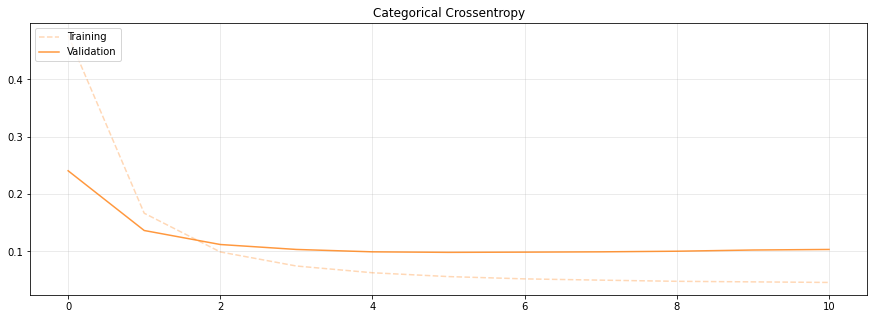

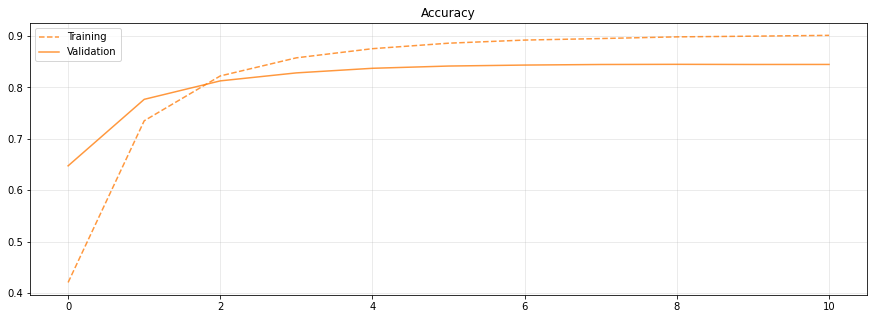

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# seq2seq_model.save('Seq2Seq')

In [17]:
seq2seq_model, encoder_state = sequence2sequence(train_dataset.num_ita_words, train_dataset.num_eng_words, 
                                                 train_dataset.max_ita_seq_length, train_dataset.max_eng_seq_length, 
                                                 ita_embedding_size=256, eng_embedding_size=256)
temp_model = tfk.models.load_model('Seq2Seq')

seq2seq_model.set_weights(temp_model.weights)

### Visualize learned embedding

In [18]:
# Save english embedding weights
weights = seq2seq_model.get_layer('encoder_embedding').get_weights()[0]

out_v = io.open('ita_vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('ita_metadata.tsv', 'w', encoding='utf-8')

for idx, word in enumerate(ita_tokenizer.word_index.keys()):
  vec = weights[idx+1]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

# Save italian embedding weights
weights = seq2seq_model.get_layer('decoder_embedding').get_weights()[0]

out_v = io.open('eng_vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('eng_metadata.tsv', 'w', encoding='utf-8')

for idx, word in enumerate(eng_tokenizer.word_index.keys()):
  vec = weights[idx+1]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# Download 'tsv' files (e.g., italian embedding)
try:
  from google.colab import files
  files.download('ita_vectors.tsv')
  files.download('ita_metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Load the embedding on https://projector.tensorflow.org/

# Real time translation

In [19]:
# Modify the model such that at each translation step the decoder takes previous prediction as current input (no teacher forcing)

# ENCODER (remains the same)
# -------
input_layers = []

encoder_inference_model = tf.keras.Model(seq2seq_model.get_layer('encoder_input').input, encoder_state)

# DECODER (modified)
# ------------------

# Define new input layers that will contain the intermediate state between decoding steps
decoder_state_input_h = tf.keras.Input(shape=[256])
decoder_state_input_c = tf.keras.Input(shape=[256])
decoder_state_input = [decoder_state_input_h, decoder_state_input_c]

# Define decoder input with seq_len = 1, since it is the single word predicted at step t-1
decoder_input_single = tf.keras.Input(shape=[1])
decoder_embedding = seq2seq_model.get_layer('decoder_embedding')(decoder_input_single)
lstm_out, h, c = seq2seq_model.get_layer('decoder_lstm')(decoder_embedding, initial_state=decoder_state_input)

# Save decoder state (for next ste inference)
decoder_state = [h, c]
decoder_out = seq2seq_model.get_layer('decoder_out')(lstm_out)

decoder_inference_model = tf.keras.Model([decoder_input_single] + decoder_state_input,
                                         [decoder_out] + decoder_state)

In [21]:
# Translation utils
ita_itow = {v:k for k, v in ita_tokenizer.word_index.items()}
eng_itow = {v:k for k, v in eng_tokenizer.word_index.items()}

def translate(input_sentence):
    
    # Prepare input sentence
    input_tokenized = ita_tokenizer.texts_to_sequences([input_sentence])
    input_tokenized = pad_sequences(input_tokenized, maxlen=train_dataset.max_ita_seq_length)
    
    # Run the encoder and get the output encoder state
    states_value = encoder_inference_model.predict(input_tokenized, verbose=False)
    
    # Set first input to 'sos' (since we start a new translation)
    curr_input = np.zeros([1, 1])  # bs x seq_length (1 x 1 at the beginning)
    curr_input[0, 0] = eng_tokenizer.word_index['sos']
    eos = eng_tokenizer.word_index['eos']
    
    # This list will contain the final translated sequence
    output_sentence = []
    
    # Cycle until max_eng_seq_length or until the 'eos' is predicted
    for _ in range(train_dataset.max_eng_seq_length):

        # Run the decoder by giving as input the previous predicted word + previous lstm state
        # (at the beginning the state are initialized with encoder state)
        preds, h_, c_ = decoder_inference_model.predict([curr_input] + states_value, verbose=False)
        
        # Get index of predicted word in the dictionary through argmax 
        word_id = np.argmax(preds[0, 0, :])
        
        # If eos end
        if eos == word_id:
            break
        
        word = ''
        
        # Convert predicted index to word and save
        if word_id > 0:
            word = eng_itow[word_id]
            output_sentence.append(word)
            
        # Update input and lstm state for next iteration
        curr_input[0, 0] = word_id
        states_value = [h_, c_]
    
    return ' '.join(output_sentence)

In [24]:
print(translate("Il Papa pesta e pesa il pepe a Pisa"), ";)")

the small bird and british soldiers ;)
